In [50]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sb
from scipy.integrate import quad
from scipy.optimize import fsolve
from scipy.linalg import solve_continuous_lyapunov
from sympy import symbols, Matrix, exp

## System equations

In [51]:
def system_dynamics(U, w1, w2, w3, Q, I1, I2, F_max, x_0, k, tau):
    U1, U2 = U
    eq1 = (-U1 + logistic(w1*U1 + I1 - Q*w2*U2 - (1 - Q)*w3*logistic(U1 + U2, F_max, x_0, k), F_max, x_0, k)) / tau
    eq2 = (-U2 + logistic(w1*U2 + I2 - Q*w2*U1 - (1 - Q)*w3*logistic(U1 + U2, F_max, x_0, k), F_max, x_0, k)) / tau
    return [eq1, eq2]

def logistic(U, F_max, x_0, k):
    exponent = -k * (U - x_0)
    with np.errstate(over='ignore'):
        exp_term = np.exp(exponent) if exponent > -700 else 0.0   # Threshold to prevent overflow
    return F_max / (1 + exp_term)

In [52]:
U1, U2 = symbols('U1 U2')

def jacobian(w1, w2, w3, Q, I1, I2, F_max, x_0, k, tau):
    # Define symbolic variables
    #U1, U2, w1, w2, w3, Q, I1, I2, F_max, x_0, k, tau = symbols('U1 U2 w1 w2 w3 Q I1 I2 F_max x_0 k tau')
    U = Matrix([U1, U2])

    # Define the logistic function symbolically
    def logistic_sym(U, F_max, x_0, k):
        return F_max / (1 + exp(-k * (U - x_0)))

    # Define the system of equations
    eq1 = (-U1 + logistic_sym(w1*U1 + I1 - Q*w2*U2 - (1 - Q)*w3*logistic_sym(U1 + U2, F_max, x_0, k), F_max, x_0, k)) / tau
    eq2 = (-U2 + logistic_sym(w1*U2 + I2 - Q*w2*U1 - (1 - Q)*w3*logistic_sym(U1 + U2, F_max, x_0, k), F_max, x_0, k)) / tau

    system_eqns = Matrix([eq1, eq2])

    # Calculate the Jacobian matrix
    jacobian_matrix = system_eqns.jacobian(U)
    return jacobian_matrix

In [53]:
# Define symbolic variables
U1, U2, w1, w2, w3, Q, I1, I2, F_max, x_0, k, tau = symbols('U1 U2 w1 w2 w3 Q I1 I2 F_max x_0 k tau')
U = Matrix([U1, U2])

# Define the logistic function symbolically
def logistic_sym(U, F_max, x_0, k):
    return F_max / (1 + exp(-k * (U - x_0)))

# Define the system of equations
eq1 = (-U1 + logistic_sym(w1*U1 + I1 - Q*w2*U2 - (1 - Q)*w3*logistic_sym(U1 + U2, F_max, x_0, k), F_max, x_0, k)) #/ tau
eq2 = (-U2 + logistic_sym(w1*U2 + I2 - Q*w2*U1 - (1 - Q)*w3*logistic_sym(U1 + U2, F_max, x_0, k), F_max, x_0, k)) #/ tau

system_eqns = Matrix([eq1, eq2])

# Calculate the Jacobian matrix
jacobian_matrix = system_eqns.jacobian(U)
jacobian_matrix

Matrix([
[F_max*k*(-F_max*k*w3*(1 - Q)*exp(-k*(U1 + U2 - x_0))/(1 + exp(-k*(U1 + U2 - x_0)))**2 + w1)*exp(-k*(-F_max*w3*(1 - Q)/(1 + exp(-k*(U1 + U2 - x_0))) + I1 - Q*U2*w2 + U1*w1 - x_0))/(1 + exp(-k*(-F_max*w3*(1 - Q)/(1 + exp(-k*(U1 + U2 - x_0))) + I1 - Q*U2*w2 + U1*w1 - x_0)))**2 - 1,   F_max*k*(-F_max*k*w3*(1 - Q)*exp(-k*(U1 + U2 - x_0))/(1 + exp(-k*(U1 + U2 - x_0)))**2 - Q*w2)*exp(-k*(-F_max*w3*(1 - Q)/(1 + exp(-k*(U1 + U2 - x_0))) + I1 - Q*U2*w2 + U1*w1 - x_0))/(1 + exp(-k*(-F_max*w3*(1 - Q)/(1 + exp(-k*(U1 + U2 - x_0))) + I1 - Q*U2*w2 + U1*w1 - x_0)))**2],
[  F_max*k*(-F_max*k*w3*(1 - Q)*exp(-k*(U1 + U2 - x_0))/(1 + exp(-k*(U1 + U2 - x_0)))**2 - Q*w2)*exp(-k*(-F_max*w3*(1 - Q)/(1 + exp(-k*(U1 + U2 - x_0))) + I2 - Q*U1*w2 + U2*w1 - x_0))/(1 + exp(-k*(-F_max*w3*(1 - Q)/(1 + exp(-k*(U1 + U2 - x_0))) + I2 - Q*U1*w2 + U2*w1 - x_0)))**2, F_max*k*(-F_max*k*w3*(1 - Q)*exp(-k*(U1 + U2 - x_0))/(1 + exp(-k*(U1 + U2 - x_0)))**2 + w1)*exp(-k*(-F_max*w3*(1 - Q)/(1 + exp(-k*(U1 + U2 - x_0))) 

## Params

In [54]:
w1, w2, w3 = 5.0, 4.0, 4.0          # Circuit weights
Q = 0.3                             # Trade-off parameter (mutual-global inhibition)
I1, I2 = 4., 4.                     # External inputs
F_max, x_0, k = 40.0, 15.0, 1./22.  # Parameters for the logistic function
tau = 20e-3                         # Time constant

## Fixed point analysis

In [55]:
def classify_fixed_point(J):
    eigenvalues = np.real(np.linalg.eigvals(J))
    if np.all(eigenvalues < 0):
        return 'Attractor'
    elif np.all(eigenvalues > 0):
        return 'Repeller'
    else:
        return 'Saddle'

    
def find_fixed_points(w1, w2, w3, Q, I1, I2, F_max, x_0, k, tau):
    def func(U):
        return system_dynamics(U, w1, w2, w3, Q, I1, I2, F_max, x_0, k, tau)
    
    initial_guesses = [(i, j) for i in np.linspace(0, F_max, 50) for j in np.linspace(0, F_max, 50)]
    fixed_points_info = []
    
    for initial_guess in initial_guesses:
        solution, infodict, ier, mesg = fsolve(func, initial_guess, full_output=True)
        if ier == 1 and not any([np.allclose(solution, fp_info[0]) for fp_info in fixed_points_info]):
            J = jacobian(w1, w2, w3, Q, I1, I2, F_max, x_0, k, tau)
            J_fp = np.array(J.subs([(U1, solution[0]), (U2, solution[1])])).astype(np.float64)
            classification = classify_fixed_point(J_fp)
            fixed_points_info.append((solution, classification))
    
    return fixed_points_info

In [56]:
fixed_points = find_fixed_points(w1, w2, w3, Q, I1, I2, F_max, x_0, k, tau)
for  point, ptype in fixed_points:
    print(f"Fixed Point: {point}, Type: {ptype}")

Fixed Point: [5.3171863  5.31718636], Type: Saddle
Fixed Point: [ 0.060767   39.62564799], Type: Attractor
Fixed Point: [39.62564799  0.060767  ], Type: Attractor


## Energy landscape

In [57]:
def potential(U1, U2, w1, w2, w3, I1, I2, Q, F_max, x_0, k, tau, ref_potential=[0,0]):
        def integrand_U1(x):
            return -system_dynamics([x, U2], w1, w2, w3, Q, I1, I2, F_max, x_0, k, tau)[0]

        def integrand_U2(y):
            return -system_dynamics([U1, y], w1, w2, w3, Q, I1, I2, F_max, x_0, k, tau)[1]

        integral_U1, _ = quad(integrand_U1, ref_potential[0], U1)
        integral_U2, _ = quad(integrand_U2, ref_potential[1], U2)

        V = integral_U1 + integral_U2
        return V

    
def potential_surface(w1, w2, w3, I1, I2, Q, F_max, x_0, k, tau, fixed_points, resolution=50):
    U1_range = np.linspace(0, F_max, resolution)
    U2_range = np.linspace(0, F_max, resolution)
    V = np.zeros((resolution, resolution))
    
    ref_potential = fixed_points[0][0]   # we take as a reference potential the saddle point in the middle
    
    for i, U1 in enumerate(U1_range):
        for j, U2 in enumerate(U2_range):
            V[i, j] = potential(U1, U2, w1, w2, w3, I1, I2, Q, F_max, x_0, k, tau, ref_potential)
    
    V -= np.min(V)
    V /= np.max(V)
    
    U1_mesh, U2_mesh = np.meshgrid(U1_range, U2_range)
    
    return U1_mesh, U2_mesh, V


def plot_potential_surface(U1, U2, V, fixed_points):
    fig = plt.figure(figsize=(10, 7), dpi=600)
    ax = fig.add_subplot(111, projection='3d')
    
    floor = -0.15
    
    surf = ax.plot_surface(U1, U2, V, linewidth=.2, edgecolor='k', rstride=6, cstride=6, cmap='viridis', alpha=0.8)
    
    contour = ax.contour(U1, U2, V, 40, cmap='viridis', linewidths=0.9, offset=np.min(V)+floor, zorder=3)
    
    point_offset = 0.03
    for point, ptype in fixed_points:
        indx_U1 = int(point[0]/F_max*U1.shape[0]) 
        indx_U2 = int(point[1]/F_max*U2.shape[0]) 
        if ptype == "Attractor":
            ax.scatter(point[0], point[1], V[indx_U1, indx_U2]+point_offset, color='g', s=100, zorder=5)
            ax.scatter(point[0], point[1], np.min(V)+floor, color='g', s=100, zorder=5)
        elif ptype == "Saddle":
            ax.scatter(point[0], point[1], V[indx_U1, indx_U2]+point_offset, color='r', s=100, zorder=5)
            ax.scatter(point[0], point[1], np.min(V)+floor, color='r', s=100, zorder=5)
        else:
            ax.scatter(point[0], point[1], V[indx_U1, indx_U2]+point_offset, color='black', s=100, zorder=5)
            ax.scatter(point[0], point[1], np.min(V)+floor, color='black', s=100, zorder=5)
            
        ax.plot([point[0], point[0]], [point[1], point[1]], [np.min(V)+floor, V[indx_U1, indx_U2]], color='black', linestyle='dashed', linewidth=1, zorder=4)

    ax.view_init(elev=10, azim=-20) #elev=25, azim=-105  //  elev=10, azim=-20
    
    fig.colorbar(surf, shrink=0.3, aspect=20)
    ax.set_xlabel('U1')
    #ax.invert_xaxis()
    ax.set_ylabel('U2')
    ax.set_zlabel('V')
    
    ax.set_zlim(floor)
    
    plt.tight_layout()
    plt.show()

In [58]:
# Estimate potential
U1_mesh, U2_mesh, V = potential_surface(w1, w2, w3, I1, I2, Q, F_max, x_0, k, tau, fixed_points, resolution=100)

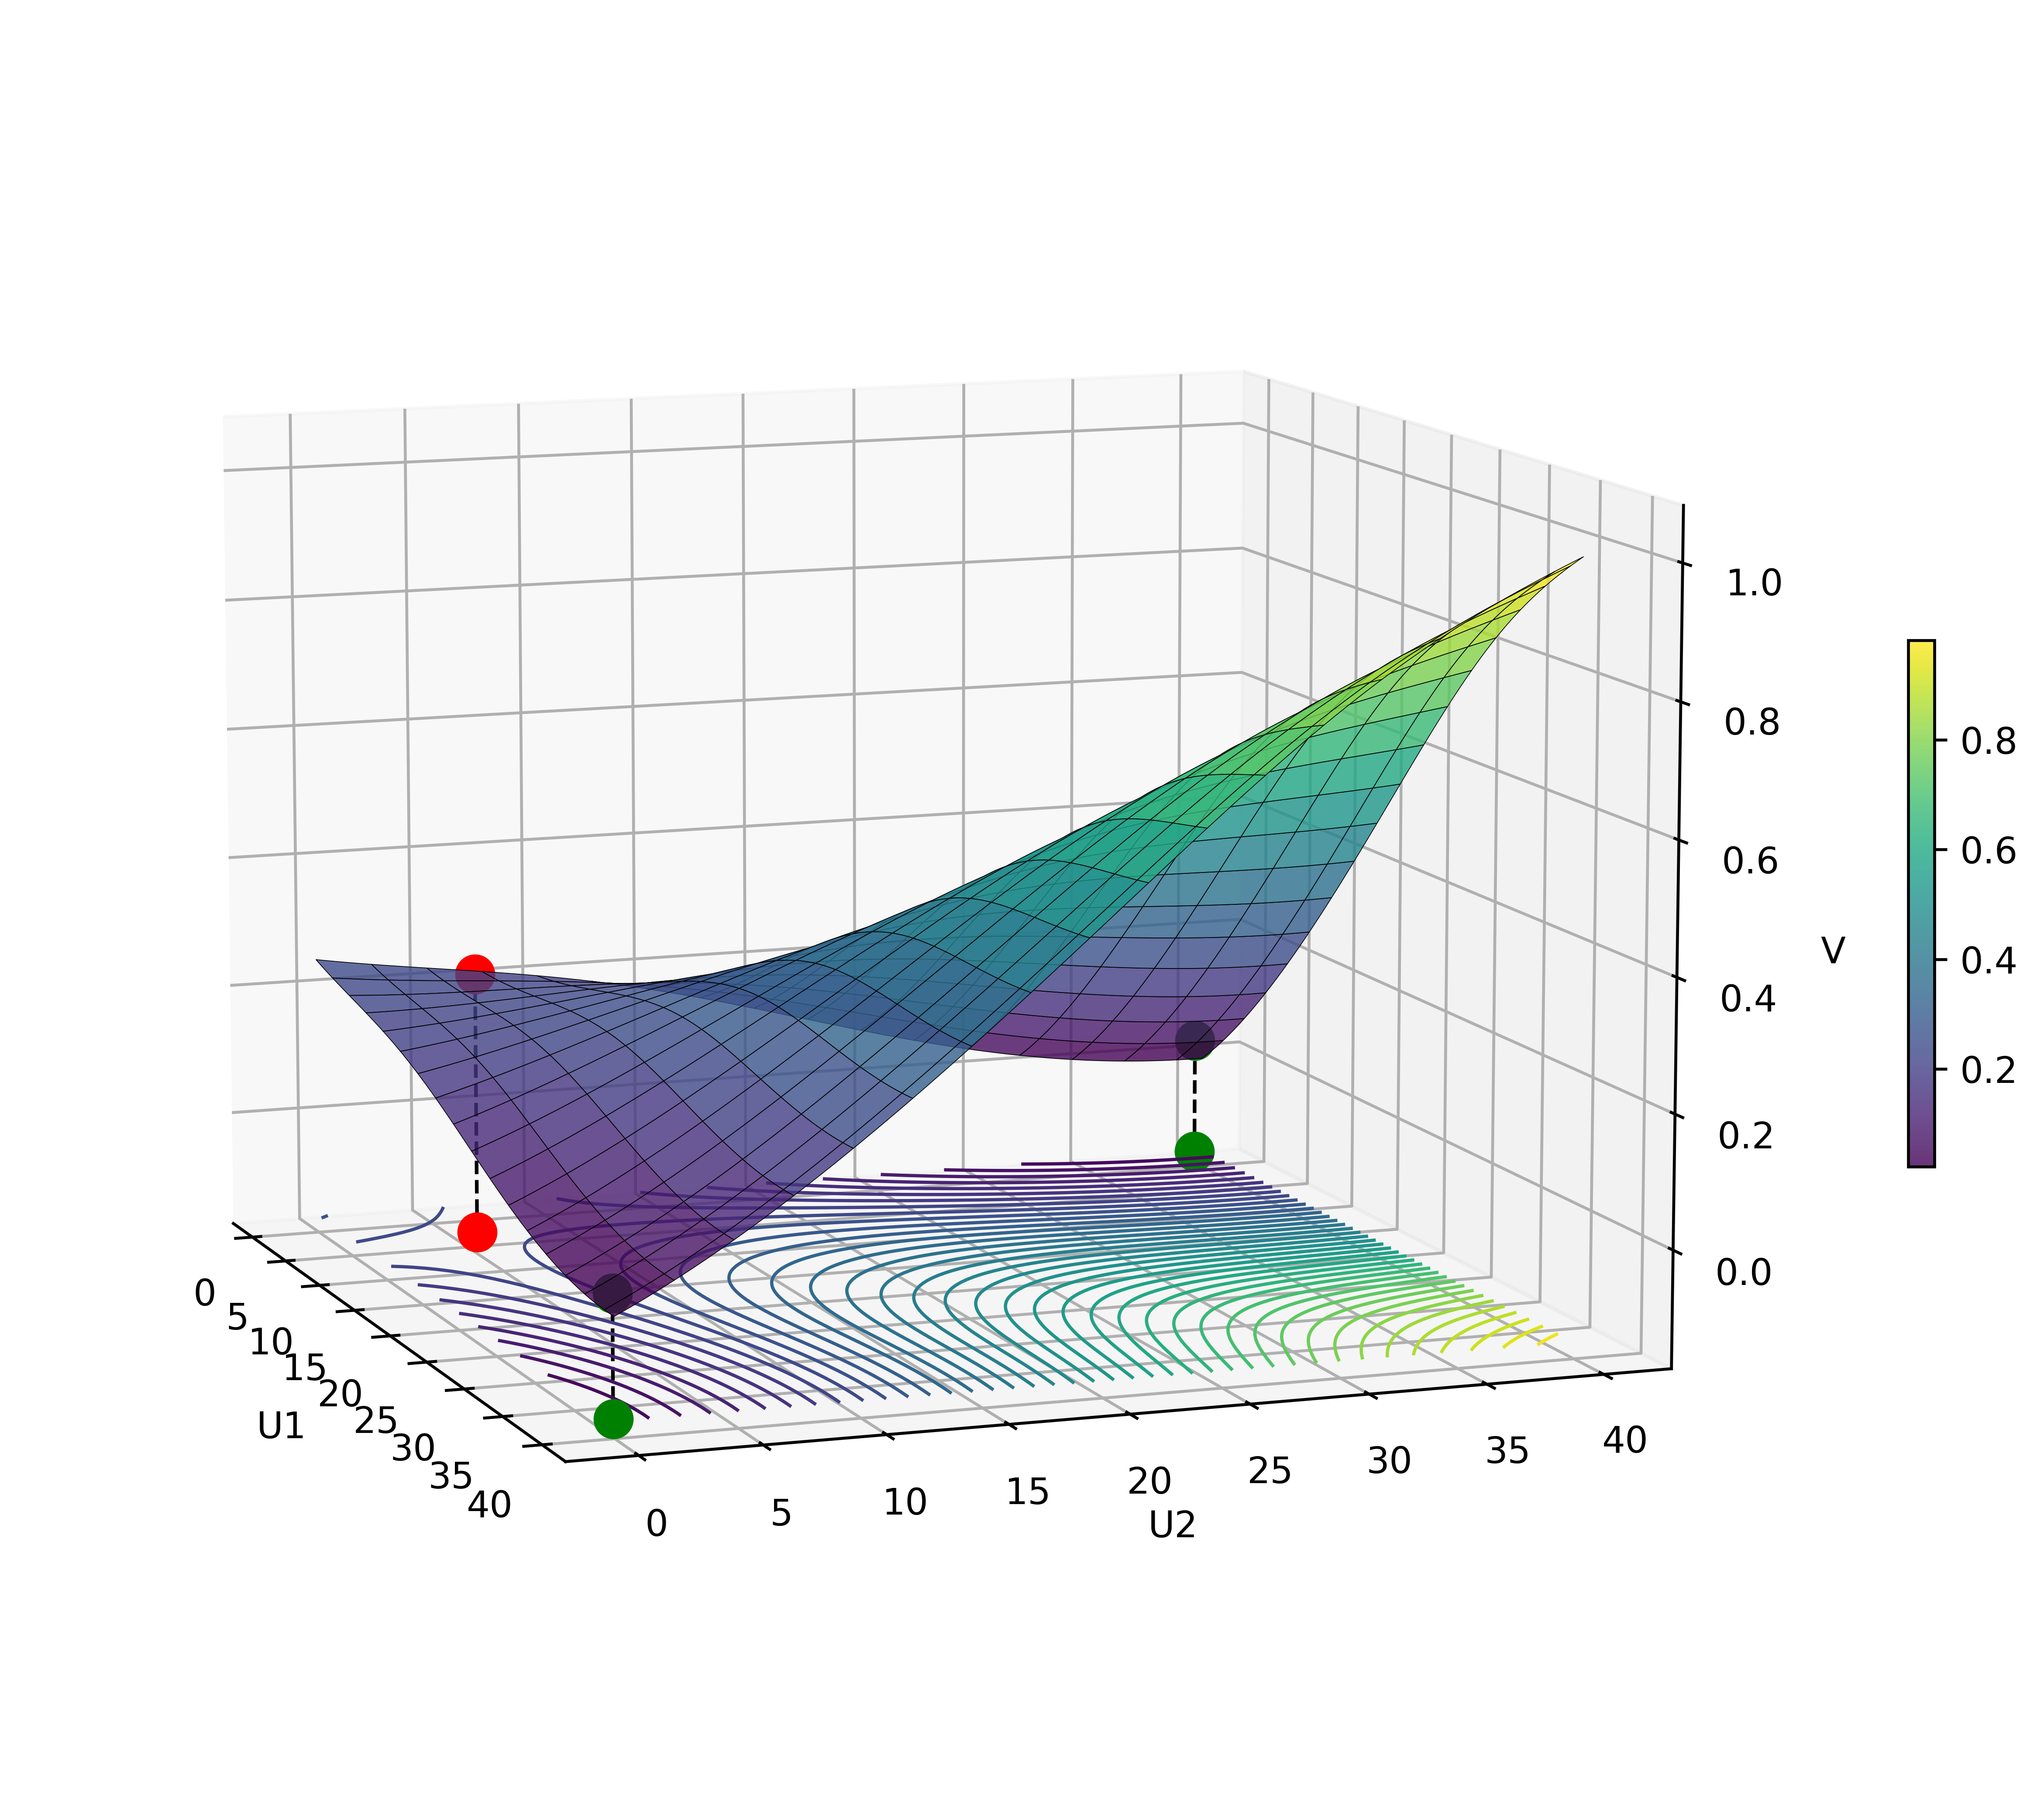

In [59]:
# Plot the potential
plot_potential_surface(U1_mesh, U2_mesh, V, fixed_points)

## Stochastic dynamics

In [60]:
def covariance_matrix(J_fp, sigma):
    """
    Computes the covariance matrix for a system of SDEs around the fixed point.

    Parameters:
    - J_fp: Jacobian matrix at the fixed point of the deterministic part of the system.
    - sigma1: Standard deviation of the noise for the first variable.
    - sigma2: Standard deviation of the noise for the second variable.

    Returns:
    - C: Covariance matrix of the fluctuations around the fixed point.
    """
    Sigma = np.diag([sigma**2, sigma**2])
    C = solve_continuous_lyapunov(J_fp, -Sigma)
    
    return C

In [12]:
res = 100
Qs = np.linspace(0, 1, res)
sigmas = np.linspace(1, 30, res)

variances = np.zeros((res, res))
covariances = np.zeros((res, res))

for i, q in enumerate(Qs):
    fixed_points = find_fixed_points(w1, w2, w3, q, I1, I2, F_max, x_0, k, tau)
    indx_fp_interest = 0
    fp = fixed_points[indx_fp_interest][0]
    J = jacobian(w1, w2, w3, q, I1, I2, F_max, x_0, k, tau)
    J_fp = np.array(J.subs([(U1, fp[0]), (U2, fp[1])])).astype(np.float64)
    for j, sigma in enumerate(sigmas):
        C = covariance_matrix(J_fp, sigma)
        variances[i,j] = np.mean([C[0,0], C[1,1]])
        covariances[i,j] = np.mean([C[0,1], C[1,0]])

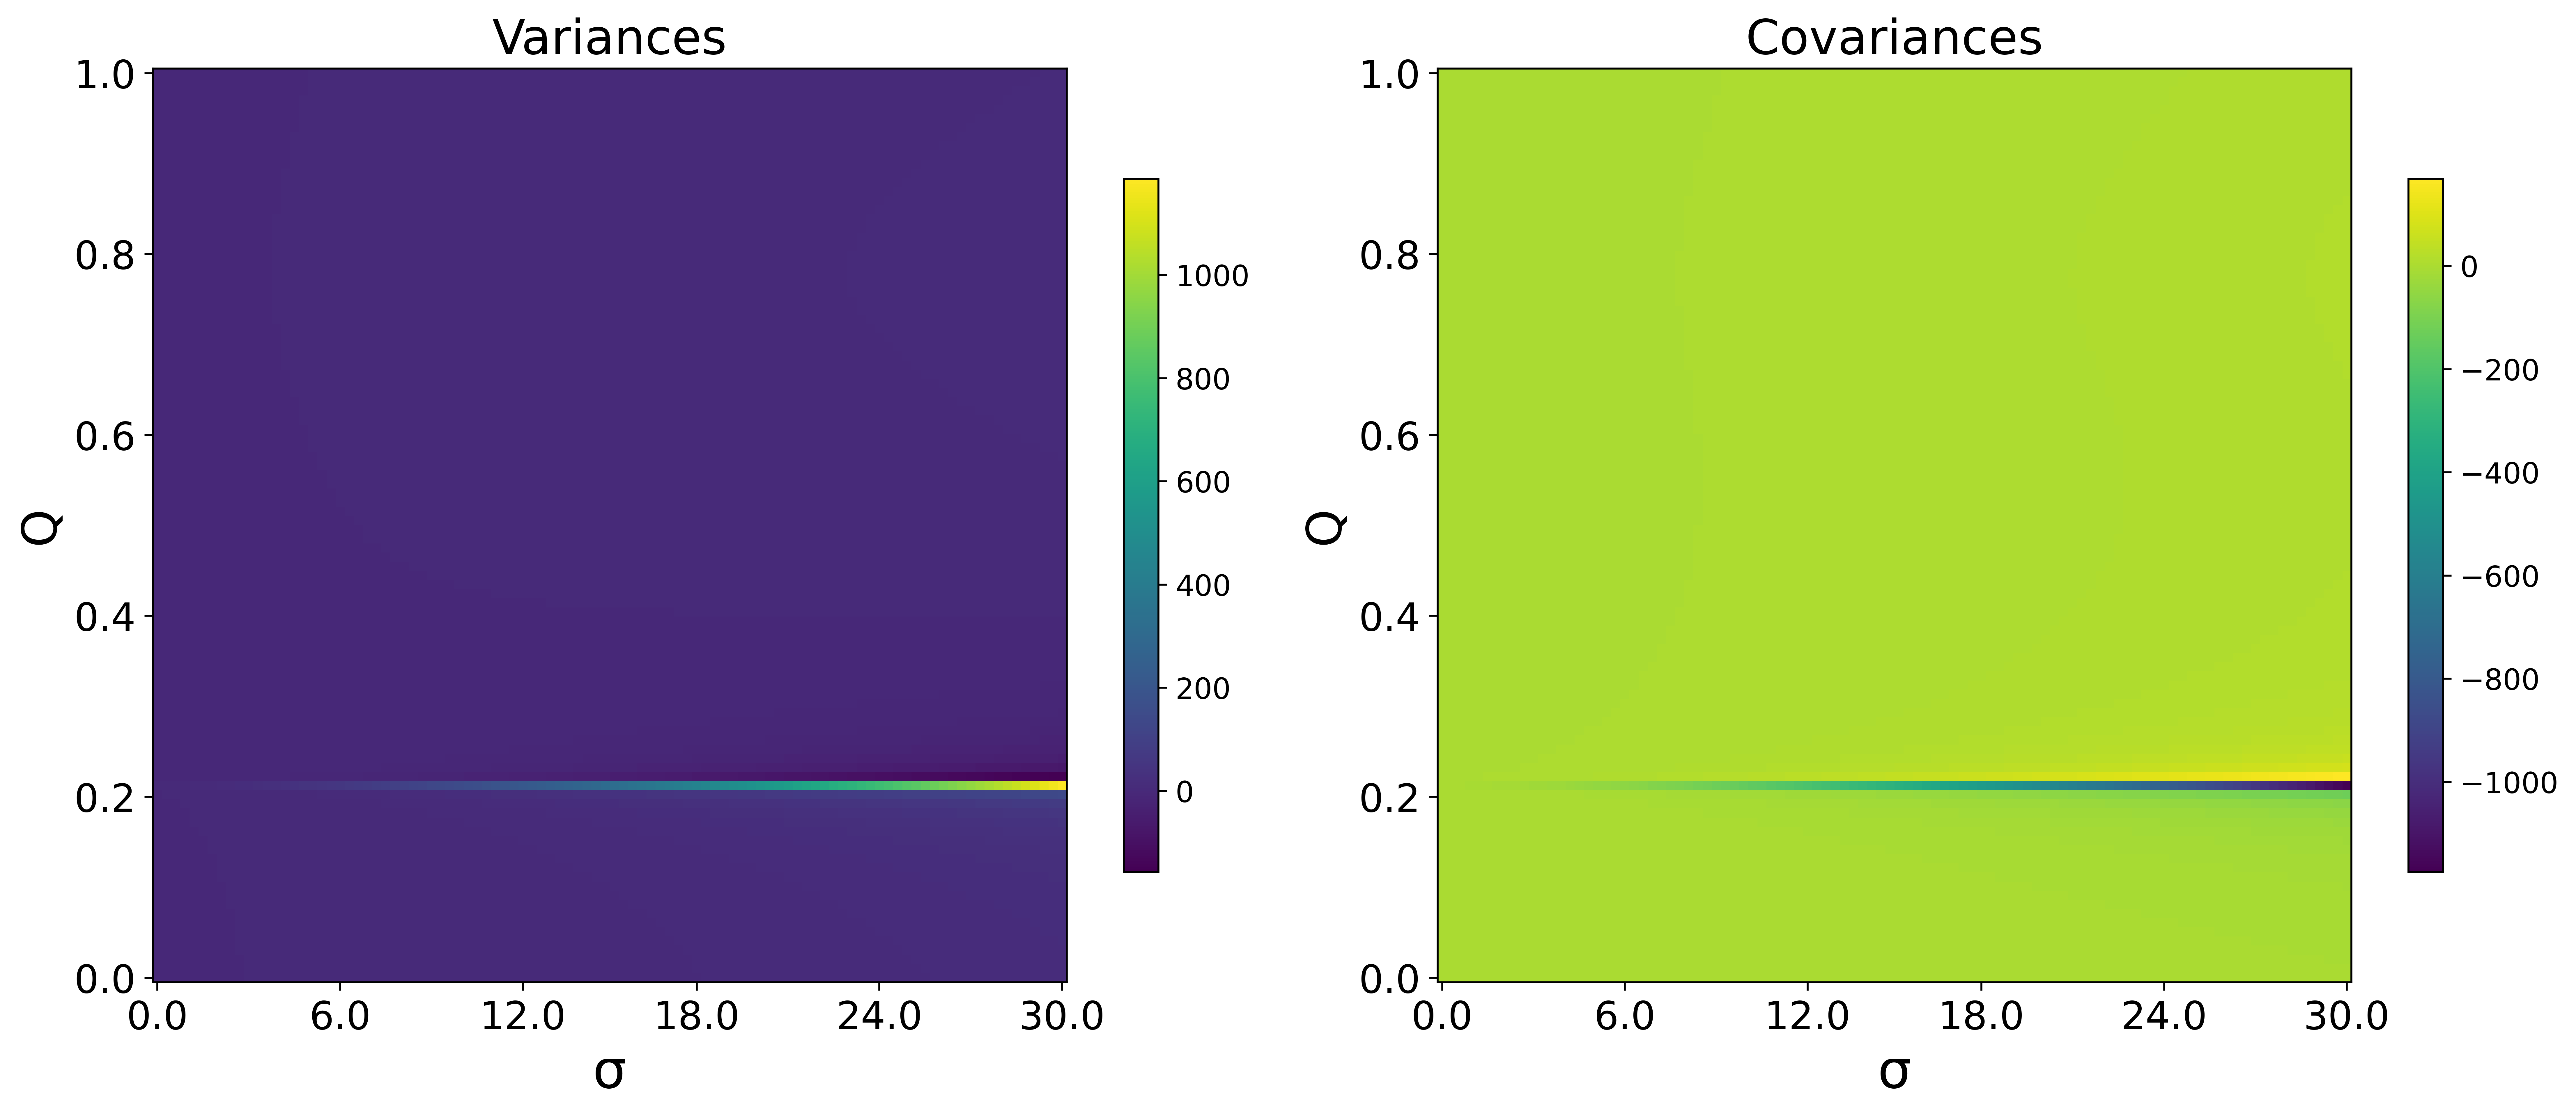

In [13]:
plt.figure(figsize=(15,7), dpi=600)

plt.subplot(121)
plt.imshow(variances, origin='lower')
plt.yticks(np.linspace(0, res-1, 6).round(1), np.linspace(0, 1, 6).round(1), fontsize=16)
plt.xticks(np.linspace(0, res-1, 6).round(0), np.linspace(0, 30, 6).round(0), fontsize=16)
plt.title('Variances', fontsize=20)
plt.ylabel('Q', fontsize=20)
plt.xlabel('σ', fontsize=22)
cb = plt.colorbar(shrink=.6)
cb.ax.tick_params(labelsize=12)

plt.subplot(122)
plt.imshow(covariances, origin='lower')
plt.yticks(np.linspace(0, res-1, 6).round(1), np.linspace(0, 1, 6).round(1), fontsize=16)
plt.xticks(np.linspace(0, res-1, 6).round(0), np.linspace(0, 30, 6).round(0), fontsize=16)
plt.title('Covariances', fontsize=20)
plt.ylabel('Q', fontsize=20)
plt.xlabel('σ', fontsize=22)
cb = plt.colorbar(shrink=.6)
cb.ax.tick_params(labelsize=12)

plt.tight_layout()
plt.show()

### Largest Lyapunov exponent approximation

In [61]:
res = 100
Qs = np.linspace(0, 1, res)

large_eigen = np.zeros(res)

for i, q in enumerate(Qs):
    fixed_points = find_fixed_points(w1, w2, w3, q, I1, I2, F_max, x_0, k, tau)
    indx_fp_interest = 0
    fp = fixed_points[indx_fp_interest][0]
    J = jacobian(w1, w2, w3, q, I1, I2, F_max, x_0, k, tau)
    J_fp = np.array(J.subs([(U1, fp[0]), (U2, fp[1])])).astype(np.float64)
    eigenvalues = np.real(np.linalg.eigvals(J_fp))
    large_eigen[i] = np.max(eigenvalues)

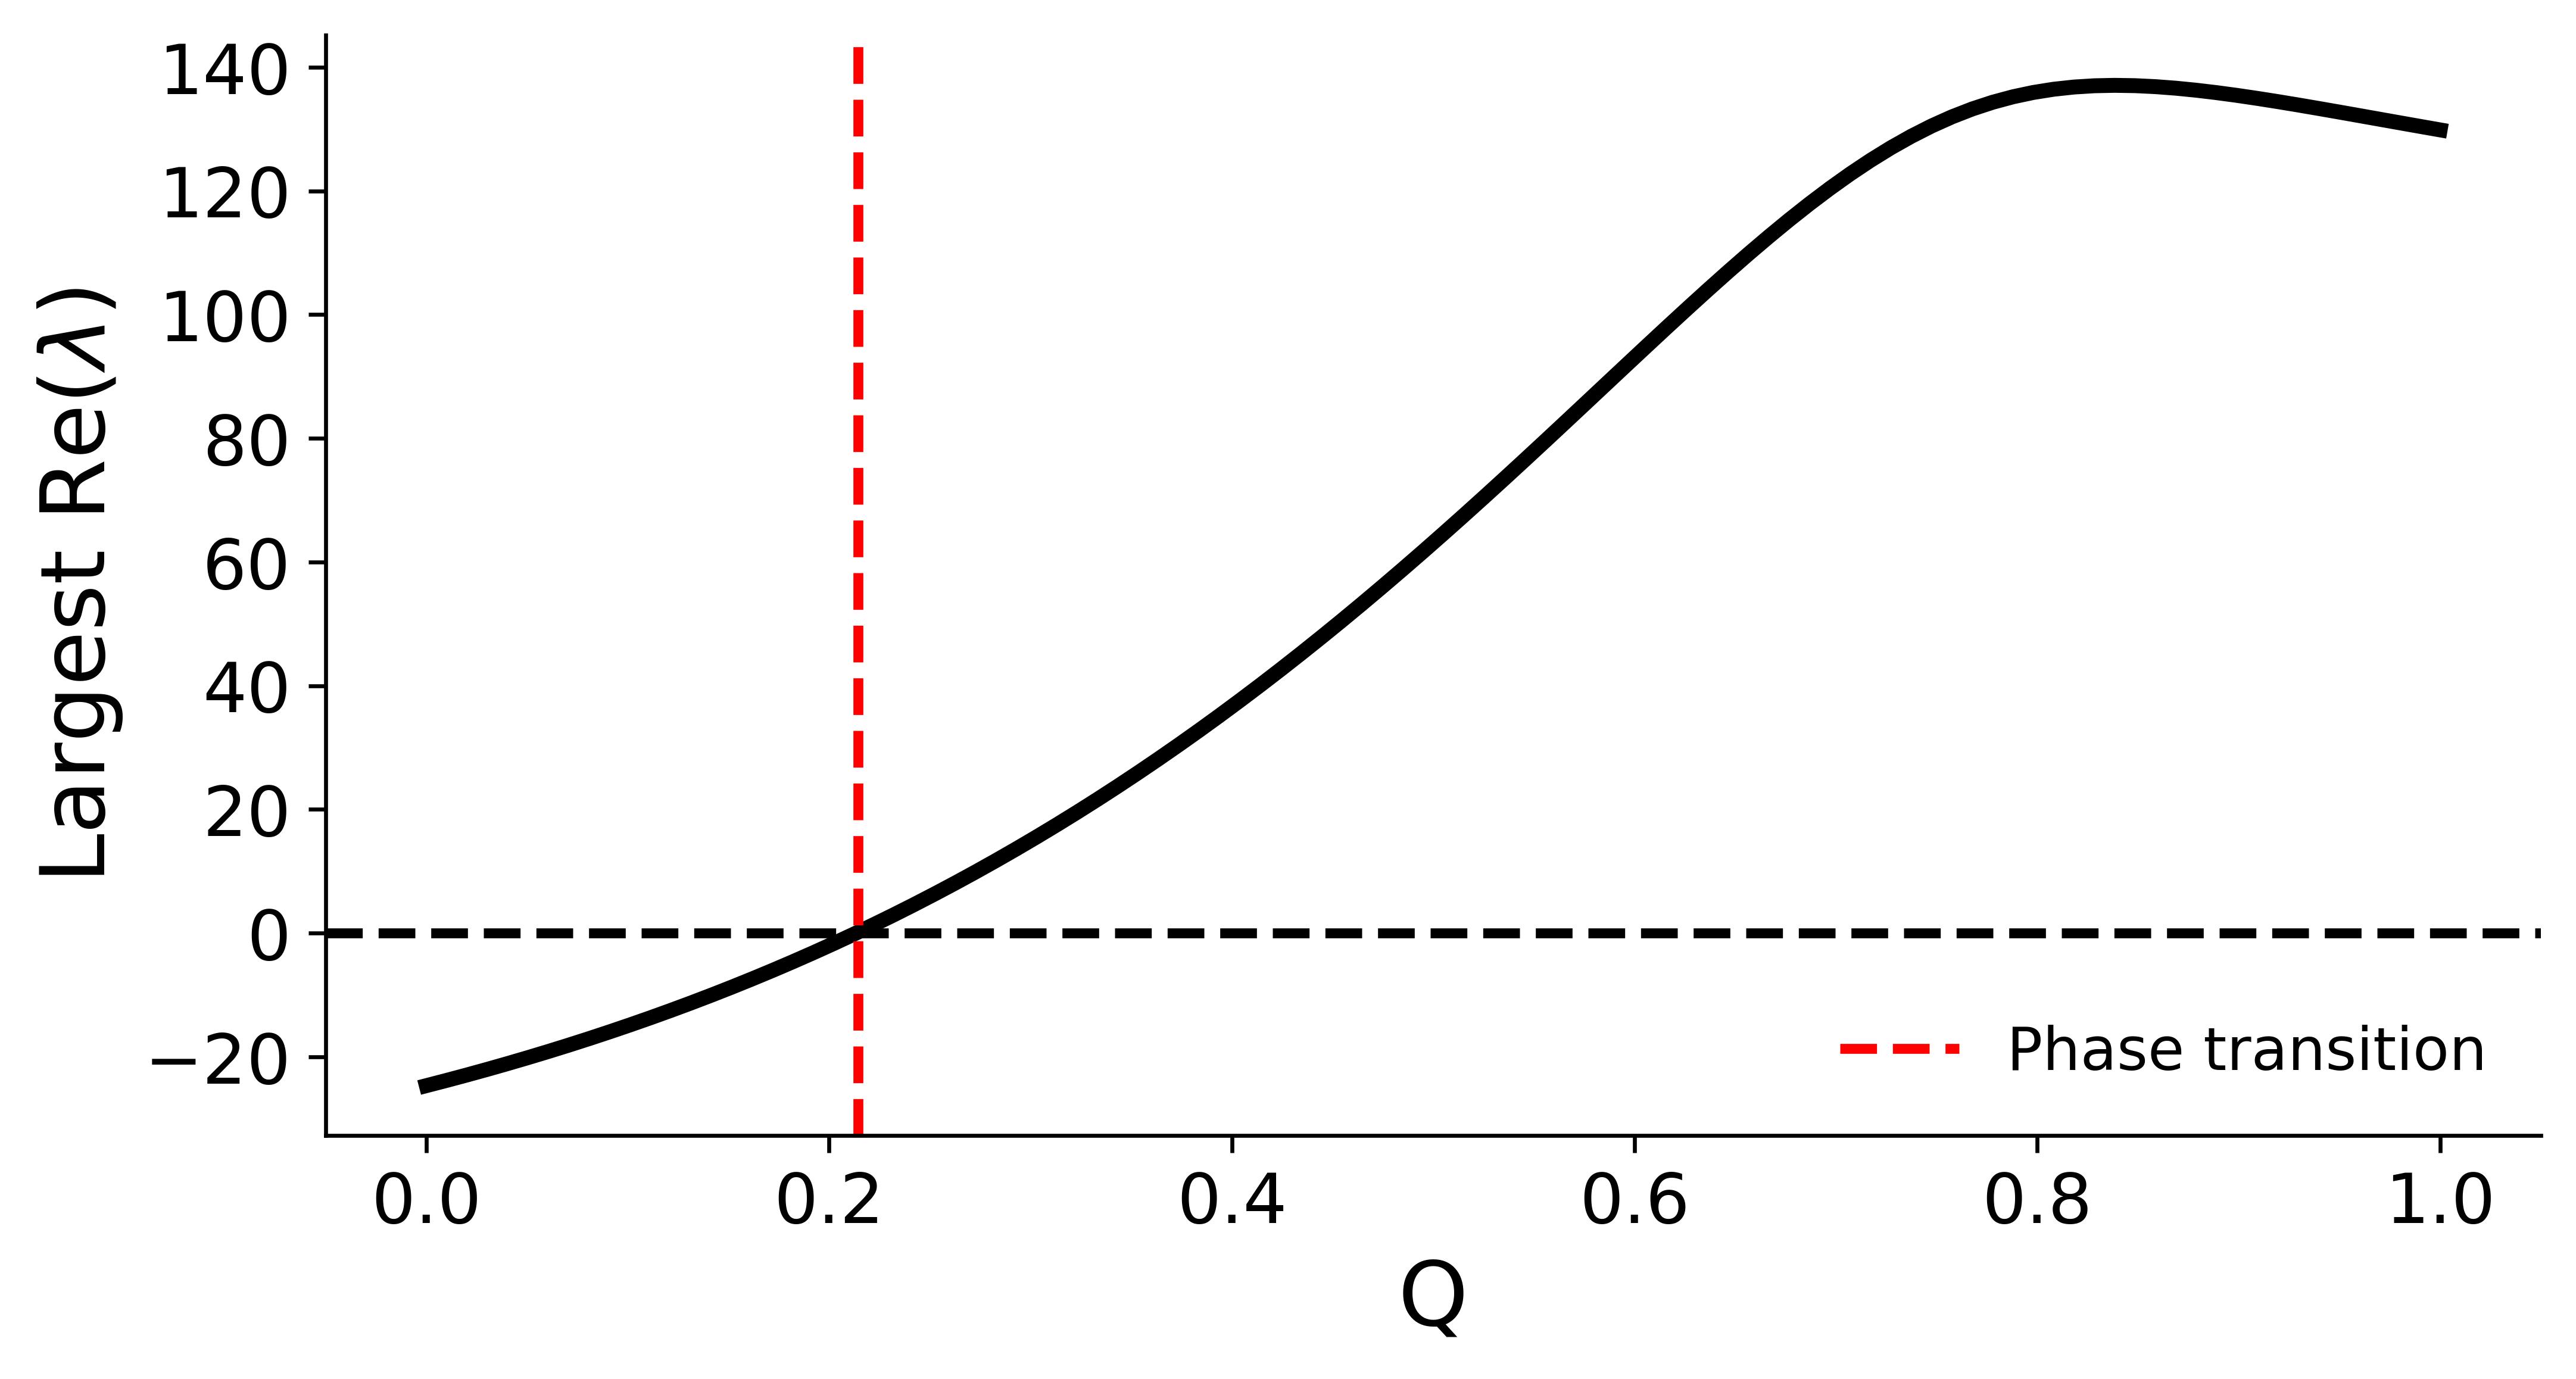

In [62]:
plt.figure(figsize=(8,4), dpi=600)

plt.plot(large_eigen, color='k', linewidth=3)
plt.axhline(y=0, color='k', linestyle='--', linewidth=2)

plt.xticks(np.linspace(0, res-1, 6).round(1), np.linspace(0, 1, 6).round(1), fontsize=14)
plt.xlabel('Q', fontsize=18)

plt.yticks(fontsize=14)
plt.ylabel('Largest Re($λ$)', fontsize=18)

phase_trans_point = Qs[np.argmin(np.abs(large_eigen))]
plt.axvline(x=phase_trans_point*res, color='r', linestyle='--', linewidth=2, label='Phase transition')

plt.legend(fontsize=12, frameon=False)

sb.despine()
plt.show()

## Transition probabilities

In [69]:
def transition_probability(fixed_points, w1, w2, w3, I1, I2, Q, F_max, x_0, k, tau, sigma, time_elapsed=1):
    """
    Estimates the transition probability between attractors using Kramers' escape problem.

    Parameters:
    - fixed_points: List of fixed points and their types.
    - sigma: Standard deviation of the noise.
    - tau: System damping parameter.
    - F_max: Maximum value of the logistic function.

    Returns:
    - transition_probs: Dictionary of transition probabilities between attractors.
    """
    k_B = 1.38e-23                  # k_B: Boltzmann constant (default value for units in Joules/Kelvin).
    T = sigma**2 / (2 * k_B)        # T: Effective temperature related to noise intensity.
    J = jacobian(w1, w2, w3, Q, I1, I2, F_max, x_0, k, tau)
    transition_probs = {}
    for i, (fp_i, type_i) in enumerate(fixed_points):
        if type_i == 'Attractor':
            for j, (fp_j, type_j) in enumerate(fixed_points):
                if i != j and type_j == 'Attractor':
                    # Find nearest saddle point
                    saddle_point = min([fp for fp, t in fixed_points if t == 'Saddle'],
                                       key=lambda s: np.linalg.norm(np.array(s) - np.array(fp_i)))

                    # Compute Jacobian at attractor and saddle
                    J_attractor = np.array(J.subs([(U1, fp_i[0]), (U2, fp_i[1])])).astype(np.float64)
                    J_saddle = np.array(J.subs([(U1, saddle_point[0]), (U2, saddle_point[1])])).astype(np.float64)

                    # Calculate frequencies
                    omega_A = np.abs(np.real(np.linalg.eigvals(J_attractor))).min()
                    omega_s = np.abs(np.real(np.linalg.eigvals(J_saddle))).min()
                    
                    # Energy barrier
                    V_A = potential(fp_i[0], fp_i[1], w1, w2, w3, I1, I2, Q, F_max, x_0, k, tau, fixed_points[0][0])
                    V_s = potential(saddle_point[0], saddle_point[1], w1, w2, w3, I1, I2, Q, F_max, x_0, k, tau, fixed_points[0][0])
                    delta_V = V_s - V_A

                    # Kramers' escape rate
                    gamma = 1 / tau  # Example relation, adjust based on your system
                    k = (omega_A * omega_s) / (2 * np.pi * gamma) * np.exp(-delta_V / (k_B * T))

                    # Store transition probability
                    transition_probs[(i, j)] = 1 - np.exp(-k * time_elapsed)

    return transition_probs

In [93]:
Q = 0.1
sigma = 30
time_decision = 1

fixed_points = find_fixed_points(w1, w2, w3, Q, I1, I2, F_max, x_0, k, tau)
for  point, ptype in fixed_points:
    print(f"Fixed Point: {point}, Type: {ptype}")
    
probs = transition_probability(fixed_points, w1, w2, w3, I1, I2, Q, F_max, x_0, k, tau, sigma, time_elapsed=time_decision)
print(probs)

Fixed Point: [3.09372807 3.09372807], Type: Attractor
Fixed Point: [ 0.89862655 13.54132175], Type: Saddle
Fixed Point: [ 0.09203845 38.71962219], Type: Attractor
Fixed Point: [13.54132175  0.89862655], Type: Saddle
Fixed Point: [38.71962219  0.09203845], Type: Attractor
{(0, 2): 0.5243156335992141, (0, 4): 1.0, (2, 0): 1.0, (2, 4): 1.0, (4, 0): 1.0, (4, 2): 1.0}
